In [2]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings, useful for cleaner output

import nltk
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
import xgboost as xgb  
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



df = pd.read_csv('D:/datasets/review data.csv', encoding='latin-1')
df

,review,label
0,"After 6 years of faithful service, my hard dri...",0
1,So far so good - this is a comprehensive and p...,0
2,This has been a great and easy software to use...,0
3,This router is great. The setup and installati...,0
4,Overview\n\nThis is a great array for someone ...,0
...,...,...
3820,"Item: Cyberlink PowerDVD 14 Ultra, Rating 4.5 ...",0
3821,For nearly 3 years my desktop computer has had...,0
3822,And H&R Block kept up with the rules and regul...,0
3823,I was fortunate enough to be a Beta tester thi...,0


In [4]:
# Check for missing values in the column
print(f'missing data in review: {sum(df.review.isnull())}')
print(f'missing data in label: {sum(df.label.isnull())}')

missing data in review: 1
missing data in label: 0


In [16]:
null_rows = df.isnull().any(axis=1)
null_indices = df[null_rows].index
df.loc[list(null_indices)]

,review,label
2175,NaN,0


In [4]:
# Drop rows where the 'review' column is missing
df = df.dropna(subset=['review'])

print(f'missing data in review: {sum(df.review.isnull())}')
print(f'missing data in label: {sum(df.label.isnull())}')

missing data in review: 0
missing data in label: 0


In [5]:
# Load the list of stopwords from NLTK
stopwords = nltk.corpus.stopwords.words('english')

# Define the text cleaning function
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.findall(r'\b\w+\b', text)
    text = [word for word in tokens if word not in stopwords]
    return text

In [6]:
minority_count = df[df['label'] == 1].shape[0]
majority_count = df[df['label'] == 0].shape[0]
total_count = len(df)

minority_ratio = minority_count / total_count  # Proportion of the minority class
majority_ratio = majority_count / total_count  # Proportion of the majority class

print(f"Minority class ratio: {minority_ratio:.4f}")
print(f"Majority class ratio: {majority_ratio:.4f}")

Minority class ratio: 0.0228
Majority class ratio: 0.9772


In [7]:
# Splitting data into training and testing sets
X = df['review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Vectorizing the text data using TF-IDF with custom cleaning function
vectorizer = TfidfVectorizer(analyzer=clean_text)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Handling class imbalance using SMOTEENN (SMOTE + Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=123)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_tfidf, y_train)

In [8]:
print(f'shape of original training set: {y_train.shape}')
print(f'shape of SMOTE training set: {y_train_resampled.shape}')

shape of original training set: (3059,)
shape of SMOTE training set: (4329,)


In [9]:
from collections import Counter

print(f'y train: {dict(Counter(y_train))}')
print(f'y train resampled: {dict(Counter(y_train_resampled))}')

y train: {0: 2989, 1: 70}
y train resampled: {0: 1383, 1: 2946}


In [10]:
# Calculate the scale_pos_weight: ratio of majority class to minority class in the resampled data
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Set up the XGBoost model with specified hyperparameters
model = xgb.XGBClassifier(
    n_estimators=300,  # Increased number of boosting rounds (trees)
    learning_rate=0.05,  # Reduced learning rate for more stable model
    max_depth=6,  # Default depth of trees
    scale_pos_weight=scale_pos_weight,  # Set the scale_pos_weight to handle imbalance
    random_state=123,
    eval_metric='logloss'  # Evaluation metric for binary classification
)

Classification Report for Fold: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       277
           1       0.99      0.99      0.99       589

    accuracy                           0.99       866
   macro avg       0.98      0.99      0.99       866
weighted avg       0.99      0.99      0.99       866



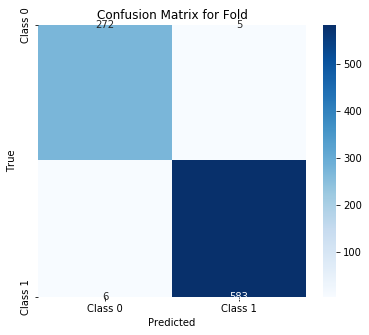

Classification Report for Fold: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       277
           1       0.99      0.99      0.99       589

    accuracy                           0.99       866
   macro avg       0.99      0.99      0.99       866
weighted avg       0.99      0.99      0.99       866



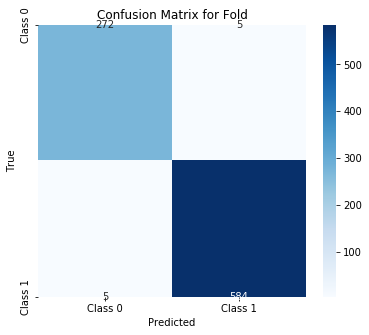

Classification Report for Fold: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       277
           1       1.00      0.99      1.00       589

    accuracy                           0.99       866
   macro avg       0.99      0.99      0.99       866
weighted avg       0.99      0.99      0.99       866



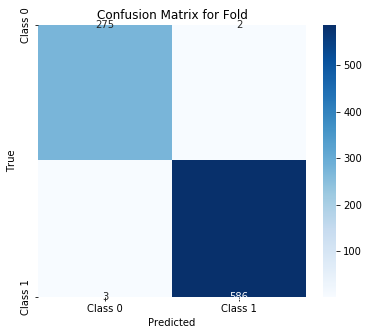

Classification Report for Fold: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       276
           1       0.99      1.00      1.00       590

    accuracy                           1.00       866
   macro avg       1.00      0.99      0.99       866
weighted avg       1.00      1.00      1.00       866



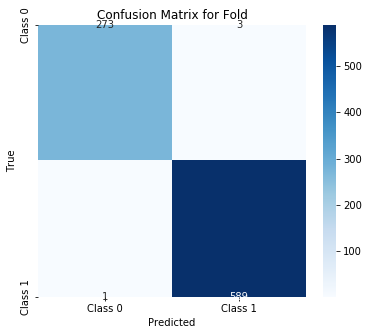

Classification Report for Fold: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       276
           1       0.99      0.99      0.99       589

    accuracy                           0.99       865
   macro avg       0.99      0.99      0.99       865
weighted avg       0.99      0.99      0.99       865



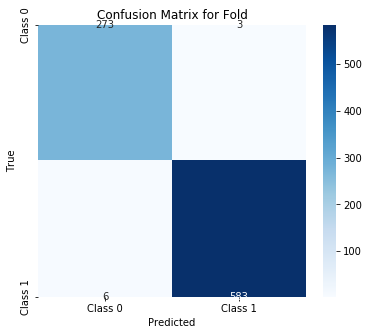

In [15]:
# StratifiedKFold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1scores = []

for train_index, val_index in skf.split(X_train_resampled, y_train_resampled):
    X_train_fold, X_val_fold = X_train_resampled[train_index], X_train_resampled[val_index]
    y_train_fold, y_val_fold = y_train_resampled[train_index], y_train_resampled[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = model.predict(X_val_fold)
    
    f1 = f1_score(y_val_fold, y_pred_fold)
    f1scores.append(f1) 
    
    # Print classification report for analysis
    print(f"Classification Report for Fold: \n{classification_report(y_val_fold, y_pred_fold)}")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred_fold)

    
    # Display confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix for Fold')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [16]:
print(f'Mean F1 score: {np.mean(f1scores):.4f}')
print(f'Standard Deviation of F1 score: {np.std(f1scores):.4f}')
print()
print(f'List of F1 Score from StratifiedKFold cross-validation: \n{f1scores}')

Mean F1 score: 0.9934
Standard Deviation of F1 score: 0.0024

List of F1 Score from StratifiedKFold cross-validation: 
[0.9906542056074766, 0.9915110356536503, 0.9957519116397621, 0.9966159052453469, 0.9923404255319148]
